# Startup Success Prediction
Startups are young companies founded to develop a unique product or service with the intention to disrupt industries and change the world while doing it at scale. Startups aim to grow very fast starting with a product called minimum viable product (MVP) that will serve as a test to see whether the product is something the customer wants to use. From there, it will go through iterative growth an innovation looking to rapidly expand its customer base to establish itself in a larger market. The ultimate goal, implicitly or explicitly, is going public through a process known as Initial Public Offering (IPO). Going public offers a chance to investors to cash out, this is known as an exit.
<br>
Before going public, startups go through several rounds of funding where venture capital firms invest tens or hundreds of millions into these companies hoping to receive the more than 200,000% return Peter Thiel saw when he invested in Facebook 8 years before IPO. However, about 90% of startups fail. Therefore, investors have a very high chance of not getting any return on their investment. This model aims to help rich people get richer. Estimates from this model can then be used to determine whether it is worth investing in a startup.
<br>

### Objective
The objective is to predict whether a startup turns into a success or a failure. The success of a company is defined as the event that gives the company's founders and investors a large sum of money through the process of M&A (Merger and Acquisition) or an IPO. A company would be considered as failed if it had to be shut down.
<br>

### Dataset Description
The data contains industry trends, investment insights (total funding, number of investors, etc.), individual company information (location, industry, etc.), and whether or not the startup has been acquired.
<br>
The data set has 49 features. Most features in the dataset are self-explanatory. Here we list features that might need further description:
**age_first_funding_year**: Is the age of the company in years when it got its first funding.
**age_last_funding_year**: Is the age of the company in years when it got its last funding.
**has_VC**: Financed by venture capital firms.
**has_angel**: Financed by angel. An angel is a high-net-worth individual who invest in early stage companies.



# Data Prep

In [1]:
import idlelib.tooltip
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import GaussianNB

np.random.seed(321)
%matplotlib inline

df = pd.read_csv('data_startup.csv')
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


### Cleanup
The dataset seems to have some redundant features:
Feature **Unnamed: 0** has unique values, ranging from 1 to 1153. Makes us wonder if this was a unique identifier, perhaps an index from a previous database. Safe to drop.

In [2]:
records_count = df.shape[0]
unnamed_0 = df.iloc[:,0].unique()
print("Records in dataset:", records_count)
print("Unique values in Unnamed: 0:", len(unnamed_0))
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Records in dataset: 923
Unique values in Unnamed: 0: 923


Feature **Unnamed: 6** is missing some data but the feature seems to be just a merge of **city**, **state_code**, and **zip_code** features. Safe to drop.

In [3]:
df.loc[:, ['state_code', 'zip_code', 'city', 'Unnamed: 6']]

,state_code,zip_code,city,Unnamed: 6
0,CA,92101,San Diego,NaN
1,CA,95032,Los Gatos,NaN
2,CA,92121,San Diego,San Diego CA 92121
3,CA,95014,Cupertino,Cupertino CA 95014
4,CA,94105,San Francisco,San Francisco CA 94105
...,...,...,...,...
918,CA,94107,San Francisco,NaN
919,MA,1803,Burlington,Burlington MA 1803
920,CA,94089,Sunnyvale,NaN
921,CA,94404,San Francisco,NaN


In [4]:
df.drop(['Unnamed: 6'], axis=1, inplace=True)

Features **id** and **object_id** are identical. There is no need for either. Safe to drop both.

In [5]:
id_to_obj_id = df['id'] == df['object_id']
print("Records in dataset:", records_count)
print("Records where the id feature is equal to the object_id feature:", id_to_obj_id.sum())
df.drop(['id', 'object_id'], axis=1, inplace=True)

Records in dataset: 923
Records where the id feature is equal to the object_id feature: 923


The **labels** feature seems to be just a binary representation of the **status** feature. Safe to drop the labels feature.

In [6]:
df.loc[:, ['labels', 'status']][:20]

,labels,status
0,1,acquired
1,1,acquired
2,1,acquired
3,1,acquired
4,0,closed
5,0,closed
6,1,acquired
7,1,acquired
8,1,acquired
9,1,acquired


In [7]:
df.drop(['labels'], axis=1, inplace=True)

The state_code and state_code.1 features are identical. Safe to drop state_code.1

In [8]:
df.loc[:, ['state_code', 'state_code.1']][:20]

,state_code,state_code.1
0,CA,CA
1,CA,CA
2,CA,CA
3,CA,CA
4,CA,CA
5,CA,CA
6,CA,CA
7,CA,CA
8,MA,MA
9,CA,CA


In [9]:
state_comp = df['state_code'] == df['state_code.1']
print("Difference state_code vs state_code.1:", records_count - state_comp.sum(), "record.")
state_diff = df.loc[df['state_code'] != df['state_code.1']]
state_diff.loc[:, ['state_code', 'state_code.1']]

Difference state_code vs state_code.1: 1 record.


,state_code,state_code.1
515,CA,NaN


As shown above, further examination between the **state_code** and **state_code.1** features reveals a missing value in feature **state_code.1** in record 515. We still believe **state_code.1** should be droped.

In [10]:
df.drop(['state_code.1'], axis=1, inplace=True)

Records 832 and 124 are duplicates. Safe to drop one of them.

In [11]:
df.iloc[[124, 832]]

,state_code,latitude,longitude,zip_code,city,name,founded_at,closed_at,first_funding_at,last_funding_at,...,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
124,CA,37.54827,-121.988572,94538,Fremont,Redwood Systems,1/1/2008,NaN,10/3/2008,5/30/2012,...,1,1,0,1,1,1,0,2.25,1,acquired
832,CA,37.48151,-121.945328,94538,Fremont,Redwood Systems,1/1/2008,NaN,10/3/2008,5/30/2012,...,1,1,0,1,1,1,0,2.25,1,acquired


In [12]:
df.drop(832, axis=0, inplace=True)
# Note this creates a gap in the rows index. To reset the index use uncomment the following line:
# df = df.reset_index()

### Missing Values

In [13]:
print("Total missing values:", df.isnull().sum().sum())
missing_values = pd.DataFrame(df.isnull().sum(), columns=["Null Values"])
missing_values["% Missing Values"] = (df.isnull().sum() / len(df) * 100)
missing_values = missing_values[missing_values["% Missing Values"] > 0]
missing_values

Total missing values: 891


,Null Values,% Missing Values
closed_at,587,63.665944
age_first_milestone_year,152,16.485900
age_last_milestone_year,152,16.485900


##### Missing values in closed_at

In [14]:
closed_acquired = df.loc[(df['closed_at'].isnull()) & (df['status'] == 'acquired')]
closed_closed = df.loc[(df['closed_at'].isnull()) & (df['status'] == 'closed')]
print("Records where closed_at is missing and the startup status is acquired:", len(closed_acquired))
print("Records where closed_at is missing and the startup status is closed:", len(closed_closed))
df.loc[:, ['closed_at', 'status']][:20]

Records where closed_at is missing and the startup status is acquired: 587
Records where closed_at is missing and the startup status is closed: 0


,closed_at,status
0,NaN,acquired
1,NaN,acquired
2,NaN,acquired
3,NaN,acquired
4,10/1/2012,closed
5,2/15/2009,closed
6,NaN,acquired
7,NaN,acquired
8,NaN,acquired
9,NaN,acquired


Missing values in the **closed_at** feature seem to be related to a **status** of acquired. Makes sense, if the startup has been acquired or gone public, then it hasn't shut down. With over 63% missing values, it might be wiser to ignore this feature rather than try to impute an arbitrary value. Moreover, knowing when a startup shut down does not help us predict whether it will be successful or not. The startup has already failed.

In [15]:
df.drop(['closed_at'], axis=1, inplace=True)

##### Missing values in **age_first_milestone_year** and **age_last_milestone_year**

In [16]:
milestone_first_last = df.loc[(df['age_first_milestone_year'].isnull()) & (df['age_last_milestone_year'].isnull()) & (df['milestones'] == 0)]
print("Missing values in age_first_milestone_year and age_last_milestone_year with 0 milestones:", len(milestone_first_last))
milestone_first_last.loc[:, ['age_first_milestone_year', 'age_last_milestone_year', 'milestones']]

Missing values in age_first_milestone_year and age_last_milestone_year with 0 milestones: 152


,age_first_milestone_year,age_last_milestone_year,milestones
12,NaN,NaN,0
15,NaN,NaN,0
24,NaN,NaN,0
32,NaN,NaN,0
34,NaN,NaN,0
...,...,...,...
885,NaN,NaN,0
903,NaN,NaN,0
904,NaN,NaN,0
906,NaN,NaN,0


After an analysis of the data it was discovered that the same 152 records with missing values in **age_first_milestone_year** and **age_last_milestone_year** features have values of 0 in the **milestones** feature. We decided to zero out the missing values.

In [17]:
df['age_first_milestone_year'].fillna(value=0, inplace=True)
df['age_last_milestone_year'].fillna(value=0, inplace=True)
print("Total missing values:", df.isnull().sum().sum())

Total missing values: 0


Rename the **status** feature to **successful** and transform the values from categorical to numerical.

In [18]:
df['status'] = df.status.map({'acquired':1, 'closed':0})
df.rename(columns={'status':'successful'}, inplace=True)

# Data Exploration

#### A look into the categorical data

In [19]:
describe_cat = df.describe(include=["O"])
describe_cat.T

,count,unique,top,freq
state_code,922,35,CA,487
zip_code,922,382,94107,30
city,922,221,San Francisco,128
name,922,922,Bandsintown,1
founded_at,922,217,1/1/2003,55
first_funding_at,922,585,1/1/2008,18
last_funding_at,922,680,1/1/2008,11
category_code,922,35,software,153


#### A look into the numerical data

In [20]:
describe_num = df.describe(include=['float64', 'int64', 'float', 'int'])
describe_num.T

,count,mean,std,min,25%,50%,75%,max
latitude,922.0,3.851857e+01,3.743372e+00,25.752358,3.738887e+01,3.777928e+01,4.073065e+01,5.933523e+01
longitude,922.0,-1.035192e+02,2.239810e+01,-122.756956,-1.221998e+02,-1.183655e+02,-7.721361e+01,1.805712e+01
age_first_funding_year,922.0,2.237235e+00,2.511337e+00,-9.046600,5.746500e-01,1.449350e+00,3.578075e+00,2.189590e+01
age_last_funding_year,922.0,3.930933e+00,2.969478e+00,-9.046600,1.669175e+00,3.520550e+00,5.560925e+00,2.189590e+01
age_first_milestone_year,922.0,2.551945e+00,2.949011e+00,-14.169900,0.000000e+00,2.000000e+00,4.002700e+00,2.468490e+01
age_last_milestone_year,922.0,3.971429e+00,3.426701e+00,-7.005500,1.000000e+00,3.780850e+00,6.043175e+00,2.468490e+01
relationships,922.0,7.703905e+00,7.266762e+00,0.000000,3.000000e+00,5.000000e+00,1.000000e+01,6.300000e+01
funding_rounds,922.0,2.309111e+00,1.390562e+00,1.000000,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
funding_total_usd,922.0,2.541017e+07,1.897371e+08,11000.000000,2.712500e+06,1.000000e+07,2.465264e+07,5.700000e+09
milestones,922.0,1.841649e+00,1.323340e+00,0.000000,1.000000e+00,2.000000e+00,3.000000e+00,8.000000e+00


#### Successful startups by state

<AxesSubplot:xlabel='State', ylabel='Number of Successful Startups'>

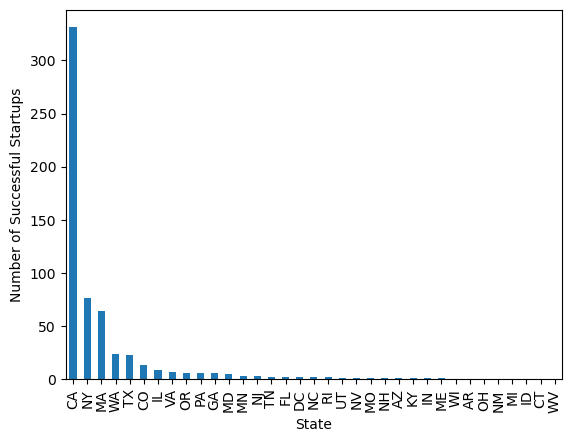

In [21]:
group_state = df.groupby('state_code')['successful']
group_state = group_state.sum().sort_values(ascending=False)
group_state.plot(kind='bar', xlabel='State', ylabel='Number of Successful Startups')

#### Successful startups by industry

<AxesSubplot:xlabel='category_code', ylabel='Number of Startups'>

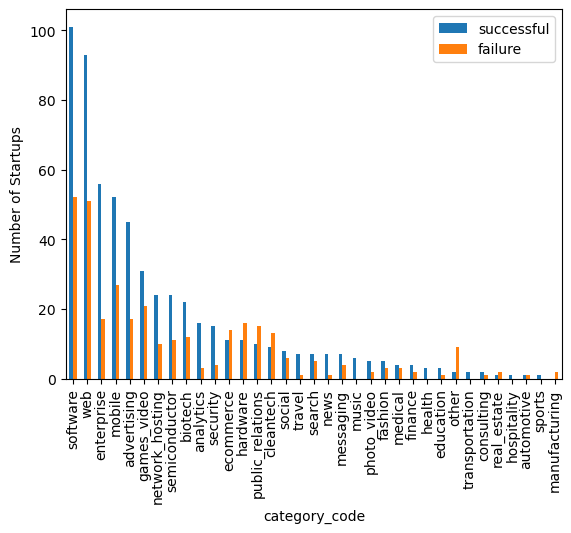

In [22]:
cat_group = pd.DataFrame(df.loc[:, ['category_code', 'successful']], columns=['category_code', 'successful'])
cat_group['failure'] = (df['successful'].map({1:0, 0:1}))
cat_group = cat_group.groupby(['category_code'])
cat_group = cat_group.sum().sort_values(by='successful', ascending=False)
cat_group.plot(kind='bar', ylabel='Number of Startups')

#### Some features on their own might be a good indicator for the startup's success. Let's see which ones have the strongest correlation.

In [23]:
df.corr().unstack().sort_values()[::-1][1:]["successful"]

relationships               0.359993
age_last_milestone_year     0.358699
milestones                  0.328264
is_top500                   0.310394
age_first_milestone_year    0.250175
has_roundB                  0.207495
funding_rounds              0.205301
avg_participants            0.186309
has_roundA                  0.183669
has_roundC                  0.164790
has_roundD                  0.140257
is_MA                       0.082016
is_CA                       0.076518
is_enterprise               0.074033
age_last_funding_year       0.073623
is_NY                       0.060307
latitude                    0.046798
is_advertising              0.044585
funding_total_usd           0.040150
is_software                 0.012791
is_mobile                   0.007560
is_consulting               0.002420
is_biotech                  0.000261
is_web                     -0.000529
is_gamesvideo              -0.025705
longitude                  -0.035456
is_othercategory           -0.043631
i

# Data Modeling

**Gaussian Naive Bayes**

In [24]:
cont_df = df.select_dtypes(include=['float', 'int'])
features = df[cont_df.columns[:-1]]
labels = df[cont_df.columns[-1]].values
#cont_features.info(verbose = True)

gauss = GaussianNB()
scaler = StandardScaler()
pipeline = Pipeline(steps = [('scaler', scaler), ('gauss', gauss)])

cross_val = cross_val_score(pipeline, features, labels, scoring = "accuracy", cv = 10)

print("Average Accuracy:", sum(cross_val) / len(cross_val))

Average Accuracy: 0.6377162225338944


**Decision Tree**

In [25]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.20)

tree = DecisionTreeClassifier(criterion = "entropy")
pipeline = Pipeline(steps = [('tree', tree)])
cross_val = cross_val_score(pipeline, features, labels, scoring = "accuracy", cv = 10)

print("Average Accuracy of Decision Tree:", sum(cross_val) / len(cross_val))

print("\nTuning our tree to find the best parameters:\n")

params = {
    "tree__max_depth": list(range(5, 41, 5)),     
    "tree__max_features": list(range(1, len(features.columns) + 1)), 
    "tree__min_samples_leaf": list(range(5, 21, 5))
}
grid_search = GridSearchCV(pipeline, param_grid = params, scoring = "accuracy", cv = 5)
grid_search.fit(features, labels)

print("Best parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Average Accuracy of Decision Tree: 0.7212482468443198

Tuning our tree to find the best parameters:

Best parameters: {'tree__max_depth': 5, 'tree__max_features': 16, 'tree__min_samples_leaf': 5}
Best Accuracy: 0.7907344300822561


**Neural Network**

In [26]:
from sklearn.neural_network import MLPClassifier

warnings.simplefilter("ignore") # hide max iterations warning

scaler = StandardScaler()
nn = MLPClassifier()
pipeline = Pipeline(steps = [('scaler', scaler), ('nn', nn)])
params = {
    'nn__hidden_layer_sizes': list(range(50, 201, 50)),
    'nn__activation': ["identity", "logistic", "tanh", "relu"],
}

grid_search = GridSearchCV(pipeline, param_grid = params, scoring = "accuracy", cv = 5)
grid_search.fit(features, labels)

print("Best parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

warnings.resetwarnings() # re-enable warnings

Best parameters: {'nn__activation': 'logistic', 'nn__hidden_layer_sizes': 150}
Best Accuracy: 0.7603055229142186
